In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from multiLevelCoSurrogates.config import data_dir

In [4]:
df = pd.read_csv('{}timing_summary.csv'.format(data_dir))
df.head()

,Unnamed: 0,function,surrogate,usage,repetition,gen_int,lambda_pre,time
0,0,bohachevsky,Kriging,reg,0,1,2,2.370154
1,1,bohachevsky,Kriging,reg,0,2,2,911.215102
2,2,bohachevsky,Kriging,reg,0,3,2,9.689295
3,3,bohachevsky,Kriging,reg,0,5,2,7.600224
4,4,bohachevsky,Kriging,reg,0,10,2,3.034205


In [5]:
df.groupby(by=['function', 'surrogate', 'usage', 'gen_int'])['time'].mean()

function          surrogate     usage      gen_int
bohachevsky       Kriging       reg        1             2.029563
                                           2           362.367661
                                           3            93.718601
                                           5            18.419717
                                           10            7.384525
                                scaled-MF  1            21.111009
                                           2           193.280545
                                           3           726.579070
                                           5           385.362458
                                           10          336.358855
                  NoSurrogate   reg        0             0.066830
                  RBF           reg        1             5.418155
                                           2            49.927766
                                           3            13.063291
                         

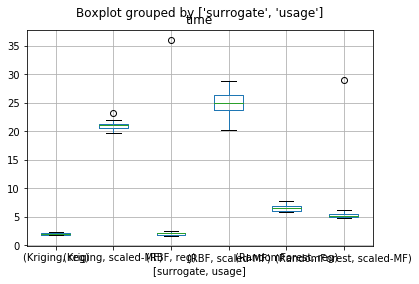

In [15]:
df[(df['function']=='bohachevsky') & (df['gen_int']==1)].boxplot(column='time', by=['surrogate', 'usage'])
    